In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import bagToCSV

In [2]:
bag_path: str = '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_03-22_03_55_0.mcap'
_message_gen = bagToCSV.get_message_generator(bag_path)

set_of_nodes: set[str] = {"A1", "A2", "A3"}

# see bagToCSV.ReducedNodeMsg
my_dataset_generator = bagToCSV.filter_status_by_node_names(_message_gen, set_of_nodes)

In [3]:
################ Chatbot special ################
data = ((x.id, x.timestamp, x.node_name, x.num_resources) for x in my_dataset_generator)

# Convert to DataFrame
df = pd.DataFrame(data, columns=["id", "timestamp", "node_name", "counter"])

# Sort by timestamp and node
df = df.sort_values(by=["timestamp", "node_name"])

# Pivot the data with forward fill to handle missing values
df_pivot = df.pivot_table(index="timestamp", columns="node_name", values="counter", aggfunc="last")
df_pivot = df_pivot.ffill().fillna(0)

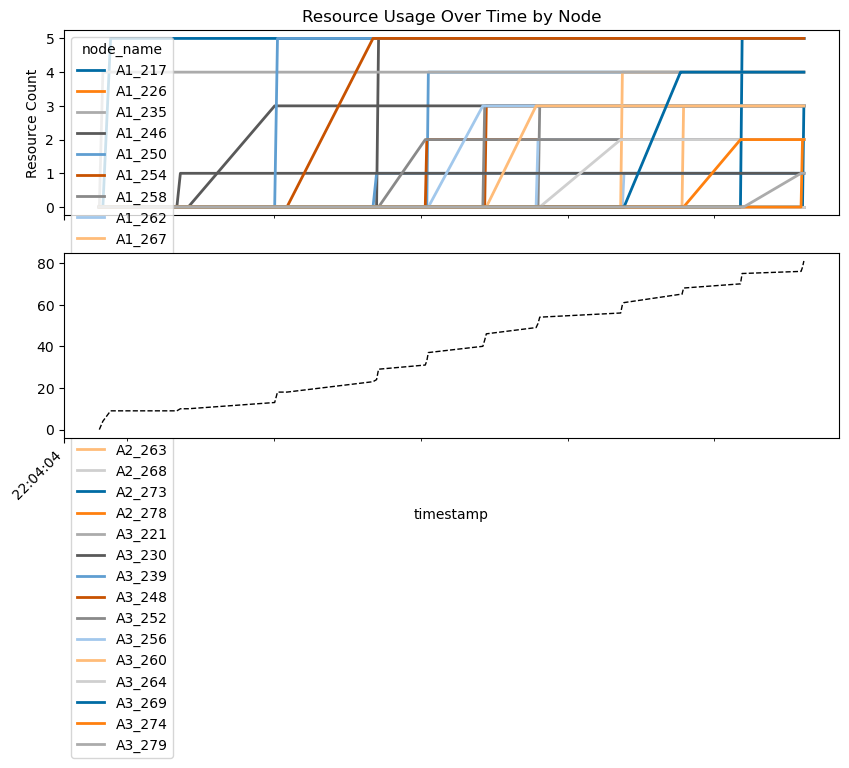

In [4]:
# Plot stacked bar chart
plt.style.use('tableau-colorblind10')
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
# fig, ax = plt.subplots(figsize=(10, 6))

# looks better when the solid lines go over the dashed line and are thicker
df_pivot.sum(axis=1).plot(style='--', label='Total', linewidth=1, color='black')
df_pivot.plot(kind="line", stacked=False, ax=ax, linewidth=2)

# Set labels and title
ax.set_title("Resource Usage Over Time by Node")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Resource Count")
plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig("foo.png")
plt.show()

In [5]:
# Remember, we are streaming the messages, so need to re-init after using them up above
_message_gen = bagToCSV.get_message_generator(bag_path)
my_dataset_generator = bagToCSV.filter_status_by_node_names(_message_gen, set_of_nodes)

In [6]:
data = ((x.id, x.timestamp, x.node_name, x.activation_potential) for x in my_dataset_generator)

# Convert to DataFrame
df = pd.DataFrame(data, columns=["id", "timestamp", "node_name", "activation"])

# Sort by timestamp and node
df = df.sort_values(by=["timestamp", "node_name"])

# Pivot the data with forward fill to handle missing values
df_pivot = df.pivot_table(index="timestamp", columns="node_name", values="activation", aggfunc="last")
df_pivot = df_pivot.ffill().fillna(0)

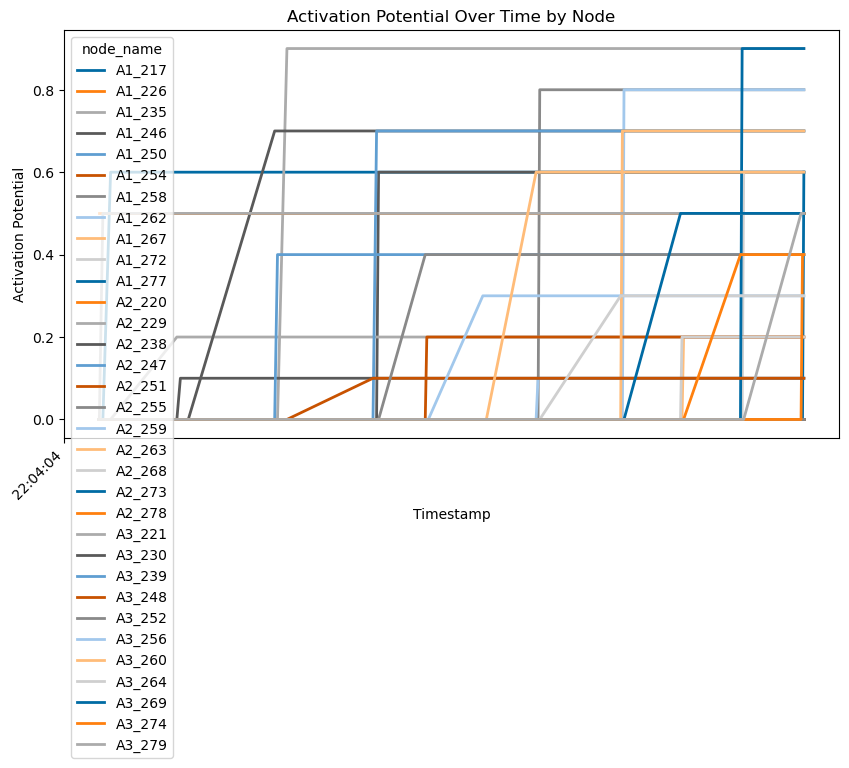

In [7]:
# Plot activation potential
plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(10, 6))

df_pivot.plot(kind="line", stacked=False, ax=ax, linewidth=2)

# Set labels and title
ax.set_title("Activation Potential Over Time by Node")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Activation Potential")
plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig("foo.png")
plt.show()